In [1]:
import tensorflow as tf
import tensorflow
from keras import models,layers
import matplotlib.pyplot as plt
import opendatasets as od

In [34]:
od.download('https://www.kaggle.com/code/konhugo/grape-desease-98-accuracy/input')

ApiException: (403)
Reason: Forbidden
HTTP response headers: HTTPHeaderDict({'Content-Type': 'application/json', 'Date': 'Sun, 30 Apr 2023 11:44:20 GMT', 'Access-Control-Allow-Credentials': 'true', 'Set-Cookie': 'ka_sessionid=938f0580423abcc7cb3426fcbdf12bdf; max-age=2626560; path=/, GCLB=CNOP56LT-vCGcQ; path=/; HttpOnly', 'Transfer-Encoding': 'chunked', 'Vary': 'Accept-Encoding', 'Turbolinks-Location': 'https://www.kaggle.com/api/v1/datasets/download/code/konhugo', 'X-Kaggle-MillisecondsElapsed': '20', 'X-Kaggle-RequestId': '3ce9249115db954b6fd032798bbe8f41', 'X-Kaggle-ApiVersion': '1.5.13', 'X-Frame-Options': 'SAMEORIGIN', 'Strict-Transport-Security': 'max-age=63072000; includeSubDomains; preload', 'Content-Security-Policy': "object-src 'none'; script-src 'nonce-vr199Y9o1WKbWvjGnLPWIg==' 'report-sample' 'unsafe-inline' 'unsafe-eval' 'strict-dynamic' https: http:; frame-src 'self' https://www.kaggleusercontent.com https://www.youtube.com/embed/ https://polygraph-cool.github.io https://www.google.com/recaptcha/ https://form.jotform.com https://submit.jotform.us https://submit.jotformpro.com https://submit.jotform.com https://www.docdroid.com https://www.docdroid.net https://kaggle-static.storage.googleapis.com https://kaggle-static-staging.storage.googleapis.com https://kkb-dev.jupyter-proxy.kaggle.net https://kkb-staging.jupyter-proxy.kaggle.net https://kkb-production.jupyter-proxy.kaggle.net https://kkb-dev.firebaseapp.com https://kkb-staging.firebaseapp.com https://kkb-production.firebaseapp.com https://kaggle-metastore-test.firebaseapp.com https://kaggle-metastore.firebaseapp.com https://apis.google.com https://content-sheets.googleapis.com/ https://accounts.google.com/ https://storage.googleapis.com https://docs.google.com https://drive.google.com https://calendar.google.com/; base-uri 'none'; report-uri https://csp.withgoogle.com/csp/kaggle/20201130;", 'X-Content-Type-Options': 'nosniff', 'Referrer-Policy': 'strict-origin-when-cross-origin', 'Via': '1.1 google', 'Alt-Svc': 'h3=":443"; ma=2592000,h3-29=":443"; ma=2592000'})
HTTP response body: b'{"code":403,"message":"Permission \\u0027datasets.get\\u0027 was denied"}'


In [5]:
BATCH_SIZE=32
IMAGE_SIZE=256
CHANNELS=3
EPOCHS=15

In [6]:
dataset =tf.keras.preprocessing.image_dataset_from_directory(
"train",
shuffle=True,
image_size=(IMAGE_SIZE,IMAGE_SIZE),
batch_size=BATCH_SIZE
)

Found 7222 files belonging to 4 classes.


In [7]:
class_names=dataset.class_names
class_names

['Black Rot', 'ESCA', 'Healthy', 'Leaf Blight']

(32, 256, 256, 3)
[3 0 1 3 0 1 3 1 0 3 1 2 3 3 2 2 0 3 1 0 2 1 0 0 3 0 3 0 0 1 2 1]


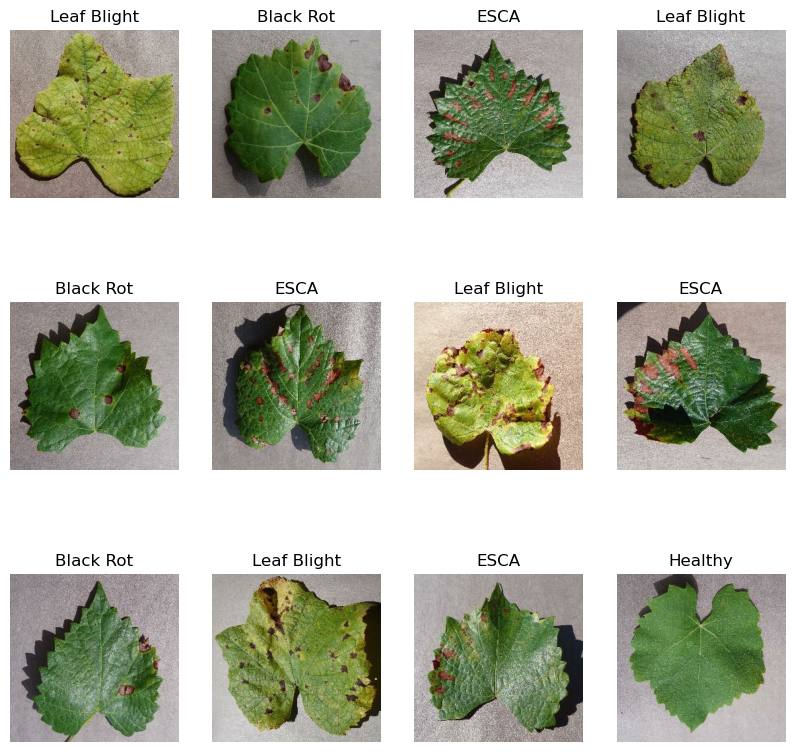

In [8]:
plt.figure(figsize=(10,10))
for image_batch,labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [9]:
# 80% ==> Training 
# 20% ==> Test 
    # 10% ==> Validation 
    # 10% ==> Test

In [10]:
train_size = 0.8
len(dataset)*train_size

180.8

In [11]:
train_ds = dataset.take(101)
len(train_ds)

101

In [12]:
test_ds = dataset.skip(101)
len(test_ds)

125

In [13]:
val_size=0.1
len(dataset)*val_size

22.6

In [14]:
val_ds = test_ds.take(12)
len(val_ds)

12

In [15]:
test_ds = test_ds.skip(12)
len(test_ds)

113

In [16]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [17]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [18]:
len(train_ds)

180

In [19]:
len(val_ds)

22

In [20]:
len(test_ds)

24

In [21]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [22]:
for image_batch,labels_batch in dataset.take(1):
    print(image_batch[0].numpy())

[[[154. 146. 144.]
  [160. 152. 150.]
  [164. 156. 154.]
  ...
  [140. 132. 130.]
  [140. 132. 130.]
  [136. 128. 126.]]

 [[163. 155. 153.]
  [164. 156. 154.]
  [161. 153. 151.]
  ...
  [144. 136. 134.]
  [140. 132. 130.]
  [132. 124. 122.]]

 [[165. 157. 155.]
  [163. 155. 153.]
  [159. 151. 149.]
  ...
  [133. 125. 123.]
  [153. 145. 143.]
  [160. 152. 150.]]

 ...

 [[169. 167. 168.]
  [169. 167. 168.]
  [174. 172. 173.]
  ...
  [236. 234. 235.]
  [205. 203. 204.]
  [219. 217. 218.]]

 [[172. 170. 171.]
  [171. 169. 170.]
  [175. 173. 174.]
  ...
  [191. 189. 190.]
  [225. 223. 224.]
  [183. 181. 182.]]

 [[189. 187. 188.]
  [188. 186. 187.]
  [188. 186. 187.]
  ...
  [222. 220. 221.]
  [195. 193. 194.]
  [220. 218. 219.]]]


In [23]:
resize_and_rescale = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
])

In [24]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [25]:
BATCH_SIZE

32

In [26]:
IMAGE_SIZE

256

In [27]:
CHANNELS

3

In [28]:
import tensorflow as tf
tf.test.gpu_device_name()

''

In [29]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    #layers.Conv2D(64, (3, 3), activation='relu'),
    #layers.MaxPooling2D((2, 2)),
    #layers.Conv2D(64, (3, 3), activation='relu'),
   #layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [30]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [31]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [32]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=15,
)

Epoch 1/15
 13/180 [=>............................] - ETA: 6:29 - loss: 1.4287 - accuracy: 0.2957

KeyboardInterrupt: 

In [34]:
scores = model.evaluate(test_ds)

14/14 [==============================] - 34s 302ms/step - loss: 4.1147e-04 - accuracy: 1.0000


In [35]:
scores

[0.0004114684707019478, 1.0]

In [36]:
history

In [37]:
history.params

{'verbose': 1, 'epochs': 15, 'steps': 101}

In [38]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
#type(history.history['loss'])

In [ ]:
#len(history.history['loss'])

In [ ]:
#history.history['loss'][:5] # show loss for first 5 epochs

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

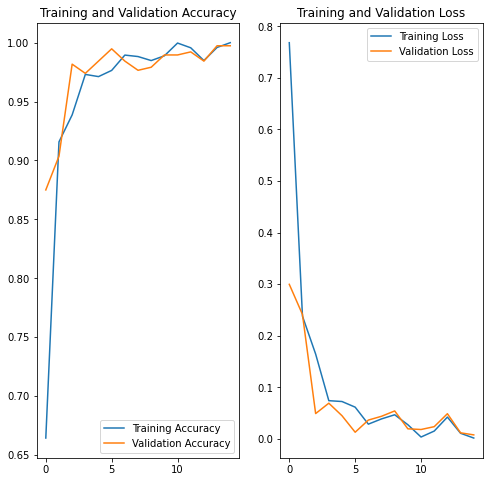

In [41]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS),acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
1/1 [==============================] - 2s 2s/step
predicted label: Grape___Leaf_blight_(Isariopsis_Leaf_Spot)


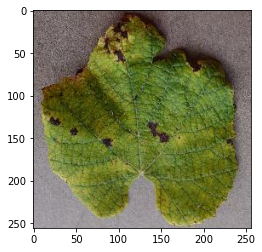

In [42]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [43]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 54ms/step


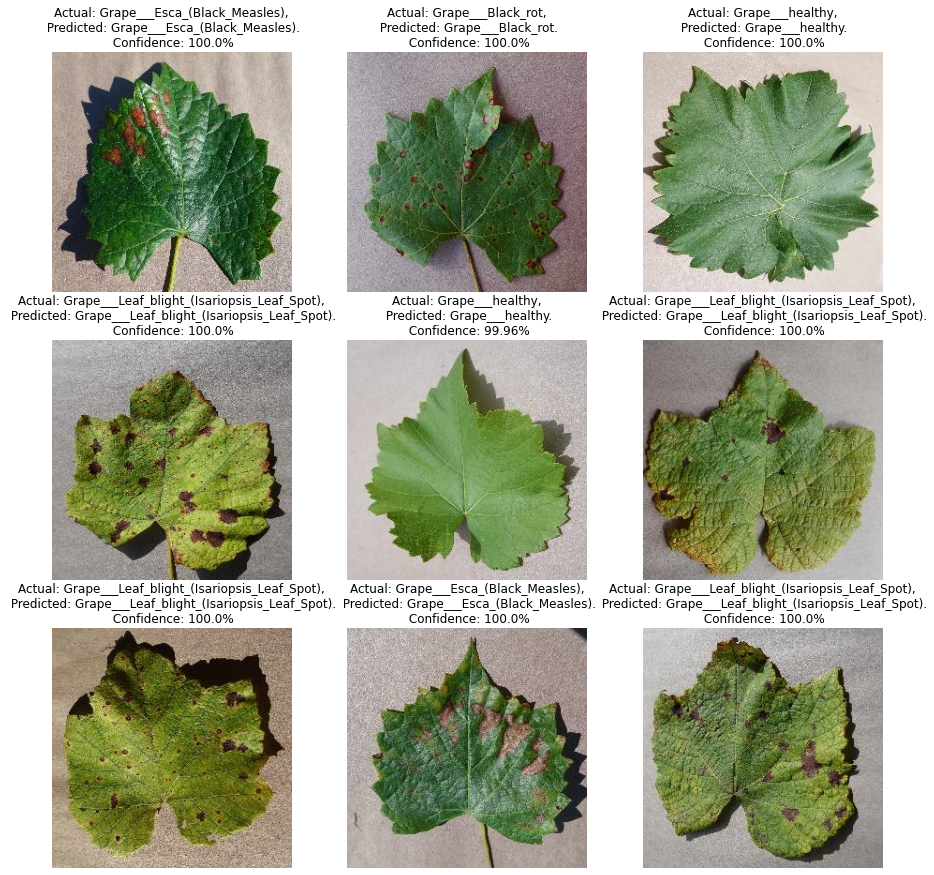

In [44]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [1]:
os.listdir("../Train")

NameError: name 'os' is not defined

In [2]:
import os
model_version=max([int(i) for i in os.listdir("H:/grapesProject/models") + [0]])+1
model.save("H:/grapesProject/models/{model_version}")

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'H:/grapesProject/models'

In [46]:
pickle.dump(model,open('model.pkl','wb'))

In [47]:
pickled_model=pickle.load(open('model.pkl','rb'))
pickled_model.predict(test_ds)

14/14 [==============================] - 4s 254ms/step


array([[9.9995422e-01, 4.3631469e-05, 2.0956809e-06, 8.0107678e-17],
       [3.8283189e-16, 1.0000000e+00, 2.8414856e-22, 0.0000000e+00],
       [1.4421830e-14, 1.0000000e+00, 1.0699568e-17, 0.0000000e+00],
       ...,
       [9.9999952e-01, 1.3861223e-09, 4.3314489e-07, 2.8640834e-17],
       [3.0185976e-10, 6.6020968e-13, 4.3582391e-09, 1.0000000e+00],
       [6.5916290e-09, 1.0000000e+00, 5.6739893e-09, 2.7929036e-20]],
      dtype=float32)